#Preparing Data

In [1]:
from zipfile import ZipFile
with ZipFile("data.zip","r") as zip_ref:
  zip_ref.extractall("data")

In [2]:
import numpy as np
np.random.seed(5) 
import tensorflow as tf
#tf.set_random_seed(2)
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import keras
from sklearn.model_selection import train_test_split

train_dir = 'data/data/train/'
eval_dir = 'asl_test/'


#2. Loading the data
#Helper function to load images from given directories
def load_images(directory,uniq_labels):
    images = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        if (directory == train_dir):
            for file in os.listdir(directory + "/" + label):
                filepath = directory + "/" + label + "/" + file
                #image = cv2.resize(cv2.imread(filepath), (64, 64))
                image = cv2.imdecode(np.fromfile(filepath, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, (64, 64))
                images.append(image)
                labels.append(idx)
        else:
            filepath = directory + "/" + label 
            #image = cv2.resize(cv2.imread(filepath), (64, 64))
            image = cv2.imdecode(np.fromfile(filepath, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (64, 64))
            images.append(image)
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)

In [3]:
CATEGORIES = sorted(os.listdir(train_dir))
#read images in train folder
images, labels = load_images(directory = train_dir, uniq_labels = CATEGORIES)
#read images in test folder



In [4]:
X_eval, y_eval = load_images(directory = eval_dir, uniq_labels = sorted(os.listdir(eval_dir)))

In [5]:
#split data to train and test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1, stratify = labels)

n = len(sorted(os.listdir(train_dir)))
train_n = len(X_train)
test_n = len(X_test)
# eval_n = len(X_eval)

print("Total number of symbols: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)
# print("Number of evaluation images: ", eval_n)

Total number of symbols:  12
Number of training images:  7146
Number of testing images:  794


In [6]:
X_train.shape



(7146, 64, 64)

In [7]:
#preprocessing
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_eval = tf.keras.utils.to_categorical(y_eval)

X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [8]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.layers import Flatten, Dense
from keras.models import Sequential
#build the model
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu', input_shape = (64, 64, 1)))
model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (4, 4)))
model.add(Dropout(0.5))
model.add(Conv2D(filters = 128 , kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128 , kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (4, 4)))
model.add(Dropout(0.5))
model.add(Conv2D(filters = 256 , kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(12, activation='softmax'))#12 classes

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       409728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0

In [10]:
#compil the model
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#fit the model
hist = model.fit(X_train, y_train, epochs = 5, batch_size = 64)

Epoch 1/5
112/112 [==============================] - 212s 2s/step - loss: 2.6043 - accuracy: 0.1111
Epoch 2/5
112/112 [==============================] - 214s 2s/step - loss: 1.3623 - accuracy: 0.5227
Epoch 3/5
112/112 [==============================] - 193s 2s/step - loss: 0.5152 - accuracy: 0.8282
Epoch 4/5
112/112 [==============================] - 225s 2s/step - loss: 0.2409 - accuracy: 0.9274
Epoch 5/5
112/112 [==============================] - 212s 2s/step - loss: 0.1310 - accuracy: 0.9574


In [11]:
#save model
model.save('ASLGray.model')

#load model
model=tf.keras.models.load_model('ASLGray.model')

INFO:tensorflow:Assets written to: ASLGray.model/assets


In [20]:
#Download model from kaggle
from IPython.display import FileLinks
FileLinks(r'ASLGray.model')

ASLGray.model/
  saved_model.pb
ASLGray.model/variables/
  variables.index
  variables.data-00000-of-00001

In [19]:
!zip -r 'ASLGray.model'

	zip warning: missing end signature--probably not a zip file (did you
	zip warning: remember to use binary mode when you transferred it?)
	zip warning: (if you are trying to read a damaged archive try -F)

zip error: Zip file structure invalid (ASLGray.model)


In [21]:
#Accuracy of model
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')

Accuracy for test images: 98.992 %


In [22]:
#prepare image to prediction
def prepare(filepath):
    image = cv2.imdecode(np.fromfile(filepath, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (64, 64))
    image=image.reshape(-1, 64, 64, 1)
    image=image.astype('float32')/255.0
    return  image

#use this function to predict images
def predict(my_model, filepath):
    prediction = model.predict([prepare(filepath)]) 
    category = np.argmax(prediction[0])
    return  CATEGORIES[category]

In [34]:
from IPython.display import Image, display


The image class is: V


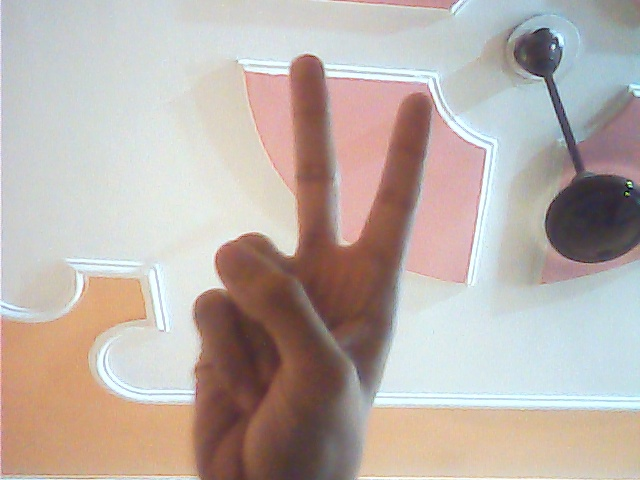

The image class is: V


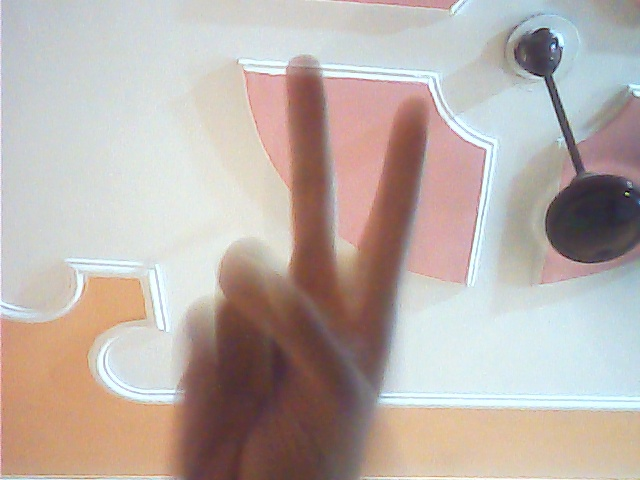

The image class is: V


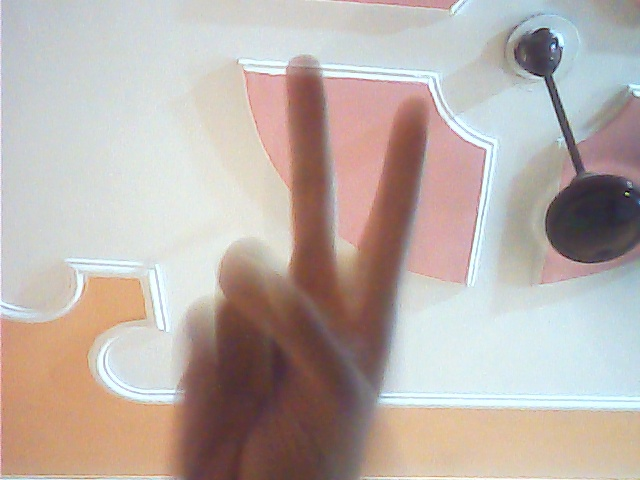

The image class is: Y


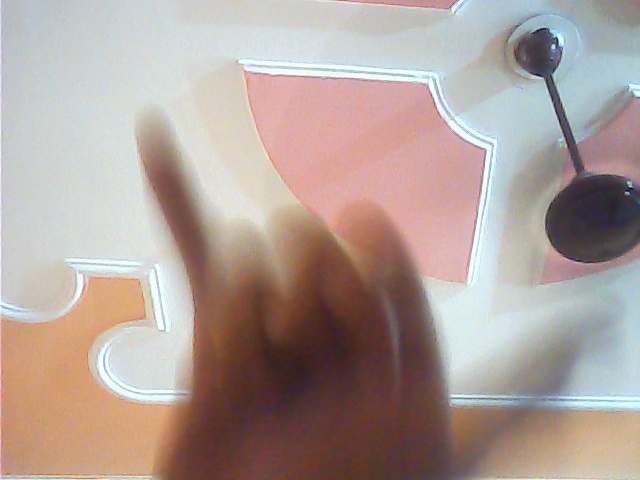

The image class is: V


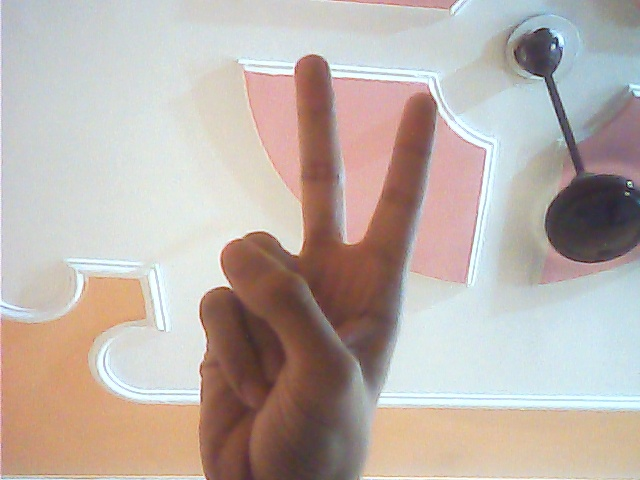

The image class is: Y


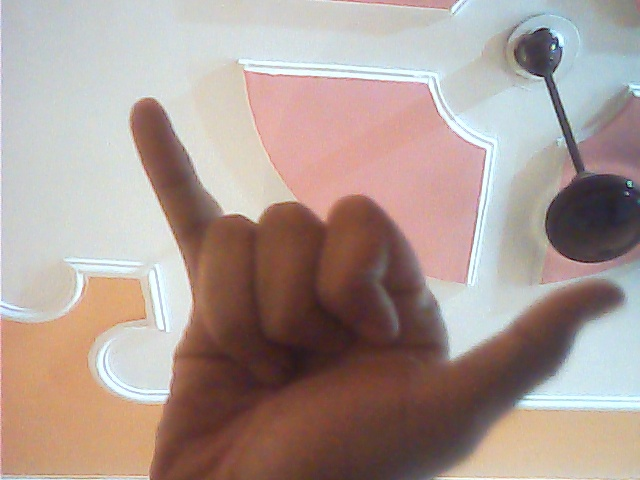

The image class is: Y


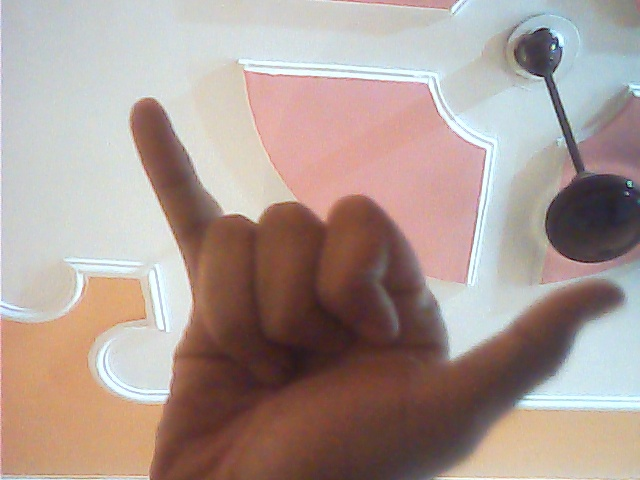

The image class is: V


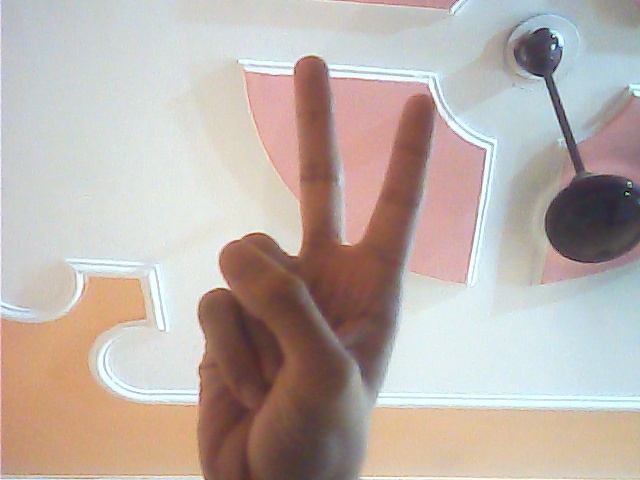

The image class is: V


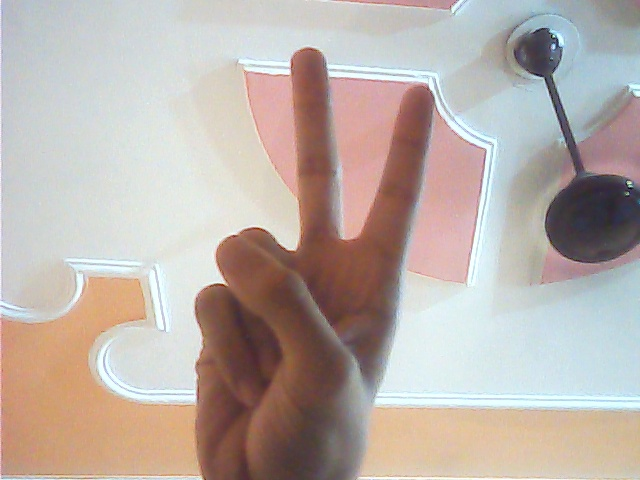

The image class is: V


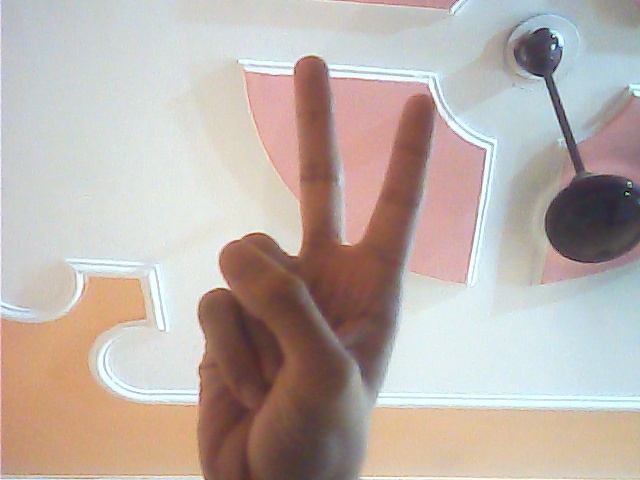

The image class is: V


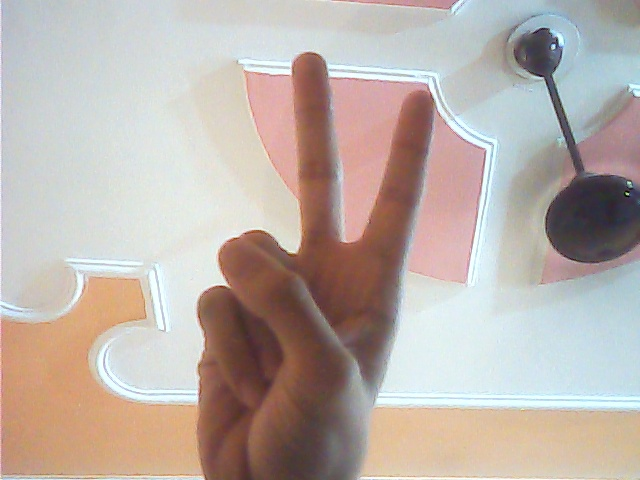

The image class is: V


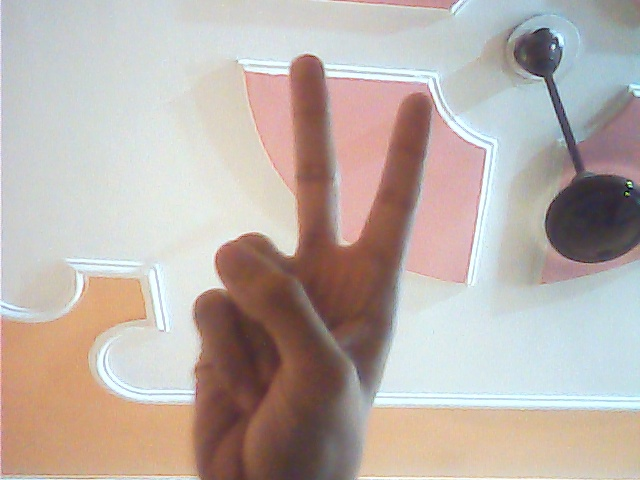

The image class is: Y


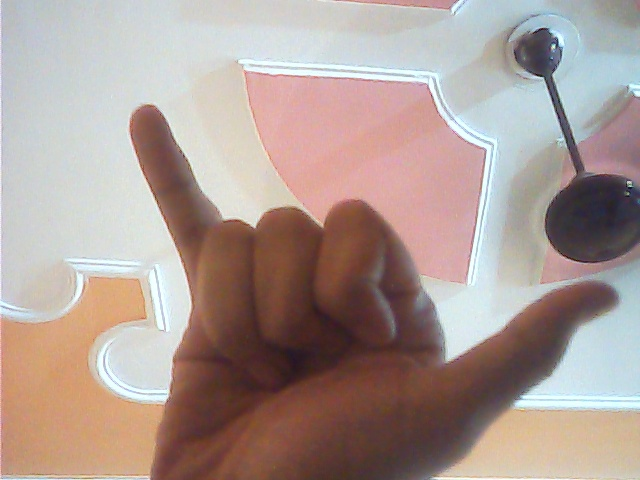

In [37]:
for file in os.listdir('test/'):
  category = predict(model,'test/'+file)
  print("The image class is: " + str(category))
  display(Image('test/'+file))
  


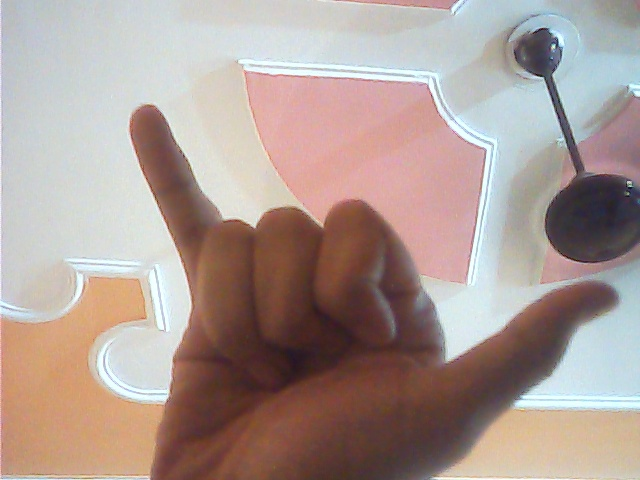